<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_3Dmodelling/blob/main/report_files_stratigraphy/05_SB1_strati_no_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_stratigraphy
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.4
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_data = r"./data"
path_DEM = r"./data/dem.tif"

In [4]:
updated_data = pd.read_csv(os.path.join(path_data, "./LoopStructural_data/updated_data_SB1.csv"))
updated_ori = pd.read_csv(os.path.join(path_data, "./LoopStructural_data/updated_ori_SB1.csv"))

In [5]:
origin = [278590.2226191017543897,6598684.8566970974206924, -40000]
maximum = [349951.3870649862801656,6654101.1388352485373616, 5000]

# 1. Contacts

In [6]:
contacts = gpd.read_file(os.path.join(path_data, "./contacts/contacts_SB1.shp"))

contacts = pd.DataFrame({'X': contacts.geometry.x, 
                         'Y': contacts.geometry.y, 
                         'Z': contacts['DEM'], 
                         'name': contacts['NAME']})

contacts = contacts.dropna().reset_index()

#remove late_basins
contacts = contacts[contacts['name']!='Late_Basins']

In [7]:
np.unique(contacts.name) #remove late_basins

array(['Granitoid', 'Lower_BF', 'Lower_Mafics', 'Middle_Mafics',
       'Mts_Gabbros', 'OraBanda_Gabbro', 'Upper_Mafics'], dtype=object)

# 2. Stratigraphic order

In [8]:
#strati_order

order = [
    ("Group_0", ['Lower_BF', 'OraBanda_Gabbro', 'Mts_Gabbros', 'Upper_Mafics', 'Middle_Mafics','Lower_Mafics',"Granitoid"   
        
        
            ]),
]

order

[('Group_0',
  ['Lower_BF',
   'OraBanda_Gabbro',
   'Mts_Gabbros',
   'Upper_Mafics',
   'Middle_Mafics',
   'Lower_Mafics',
   'Granitoid'])]

# 3. WAROX measurements

In [9]:
ig_lyr = gpd.read_file(
    os.path.join(path_data, "beddings/011_igneous_layering_with_formations.shp")).explode(ignore_index=True, 
                                                                                          index_parts=True)

measurements_df = pd.DataFrame({
    'X': ig_lyr.geometry.x, 
    'Y': ig_lyr.geometry.y,
    'Z': ig_lyr.DEM, 
    'name': ig_lyr.Name, 
    'strike': ig_lyr.STRIKE, 
    'dip':ig_lyr.DIP, 
    'polarity':1
})

In [10]:
beddings = gpd.read_file(
    os.path.join(path_data, "beddings/033_beddings_with_verticals_with_formations.shp")).explode(ignore_index=True, 
                                                                                                 index_parts=True)

measurements_df1 = pd.DataFrame({
    'X': beddings.geometry.x, 
    'Y': beddings.geometry.y,
    'Z': beddings.DEM, 
    'name': beddings.Name, 
    'strike': beddings.STRIKE, 
    'dip': beddings.DIP, 
    'polarity':1
})

In [11]:
met_foliations_s0 = gpd.read_file(
    os.path.join(path_data, "beddings/04_met_foliation_s0_with_formations.shp")).explode(ignore_index=True, 
                                                                                         index_parts=True)

measurements_df2 = pd.DataFrame({
    'X': met_foliations_s0.geometry.x, 
    'Y': met_foliations_s0.geometry.y,
    'Z': met_foliations_s0.DEM, 
    'name': met_foliations_s0.Name, 
    'strike': met_foliations_s0.STRIKE, 
    'dip': met_foliations_s0.DIP, 
    'polarity':1
})

In [12]:
measurements_df = pd.concat([measurements_df, measurements_df1, measurements_df2])

In [13]:
#rename for same names as contacts

In [14]:
# match measurements names with contacts names
measurements_df = measurements_df.replace('Ora Banda Gabbro', 'OraBanda_Gabbro')
measurements_df = measurements_df.replace('Mount_Pleasant_Gabbro', 'Mts_Gabbros')
measurements_df = measurements_df.replace('Mount_Ellis_Gabbro', 'Mts_Gabbros')
measurements_df = measurements_df.replace('Granitoids', 'Granitoid')

In [15]:
measurements_df.isnull().values.any()

False

# 4. Thicknesses

In [16]:
thickness = {
    'Granitoid': 4000,
    'Lower_Mafics': 2238, 
    'Middle_Mafics': 2407, 
    'Upper_Mafics': 3066, 
    'Mts_Gabbros': 1732, 
    'OraBanda_Gabbro': 1575, 
    'Lower_BF': 2349
}

# model

In [17]:
processor = ProcessInputData(
    contacts=contacts,
    contact_orientations=measurements_df,
    thicknesses=thickness,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum, 
    fault_locations = updated_data, 
    fault_orientations = updated_ori
)

                This will result in only a fault surface, no displacement on older features


In [18]:
model = GeologicalModel(processor.origin, processor.maximum)
model.data = processor.data
model.stratigraphic_column = processor.stratigraphic_column
model.create_and_add_foliation('Group_0')
model.update()

  0%|          | 0/1 [00:00<?, ?it/s]


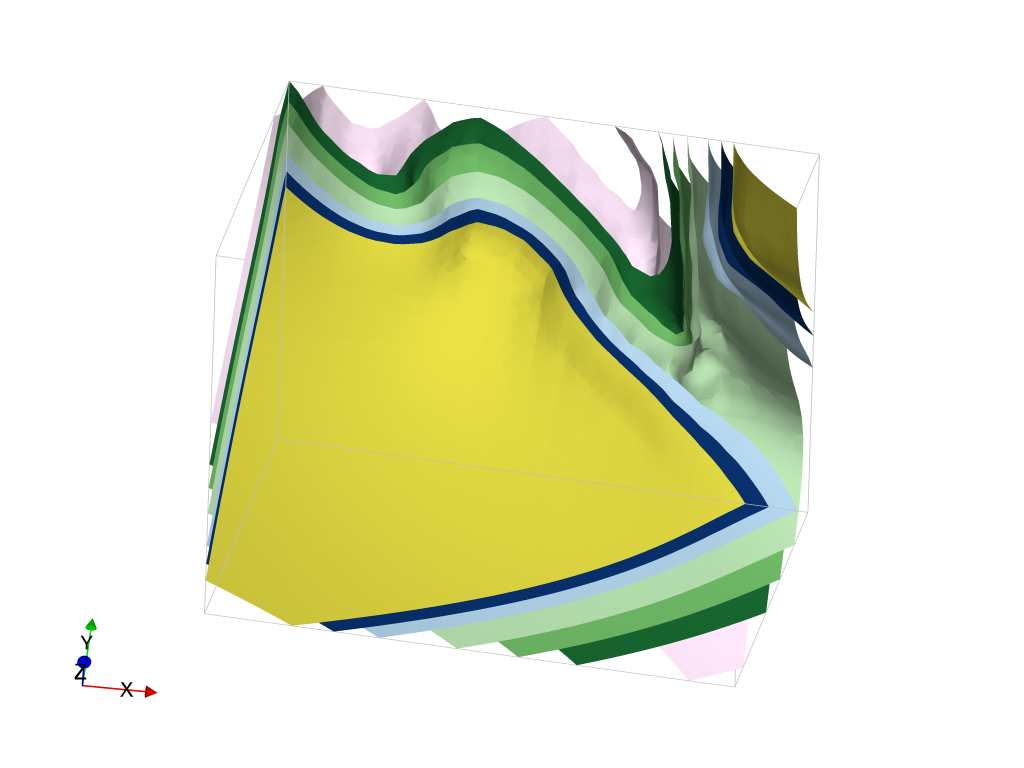

In [19]:
view = LavaVuModelViewer(model)

view.nelements = 1e5
all_names = []
all_values = []

colores = [ ['#f7dff3'] , 
      ['#17632e'], 
     ['#6cb464'],
           ['#b5dfae'], 
           ['#afd1e7'], 
            ['#08306b'], 
    ['#e0d841']
           
           ]

for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
view.display()
# view.interactive()

# Add faults

In [20]:
model = GeologicalModel(processor.origin, processor.maximum)
model.data = processor.data
model.stratigraphic_column = processor.stratigraphic_column

model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True), 

model.create_and_add_fault('Black Flag Fault', displacement = 800, nelements=1e4, force_mesh_geometry = False)

#fault_slip_vector=None, defines the horizontal slip; np.array(as a vector)

model.create_and_add_fault('F1', displacement = 1200, nelements=1e4, force_mesh_geometry = True)
model['F1'].builder.set_mesh_geometry(0.1, 0)

tang1 = np.tile([-1737.07, -2023.51,  7009.83],
                (model['Black Flag Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Black Flag Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Black Flag Fault'][0].interpolator.support.barycentre,
                vector = tang1, w=1, B=0)

model['Black Flag Fault'].add_abutting_fault(model['Boorara Fault'])
model['Black Flag Fault'].add_abutting_fault(model['Zuleika Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])
model['F1'].add_abutting_fault(model['Boorara Fault'])
model['F1'].add_abutting_fault(model['Zuleika Fault'])

model.create_and_add_foliation('Group_0', nelements = 1e5, cpw = 0.5, npw = 0.1)
model.update()

  0%|          | 0/13 [00:00<?, ?it/s]


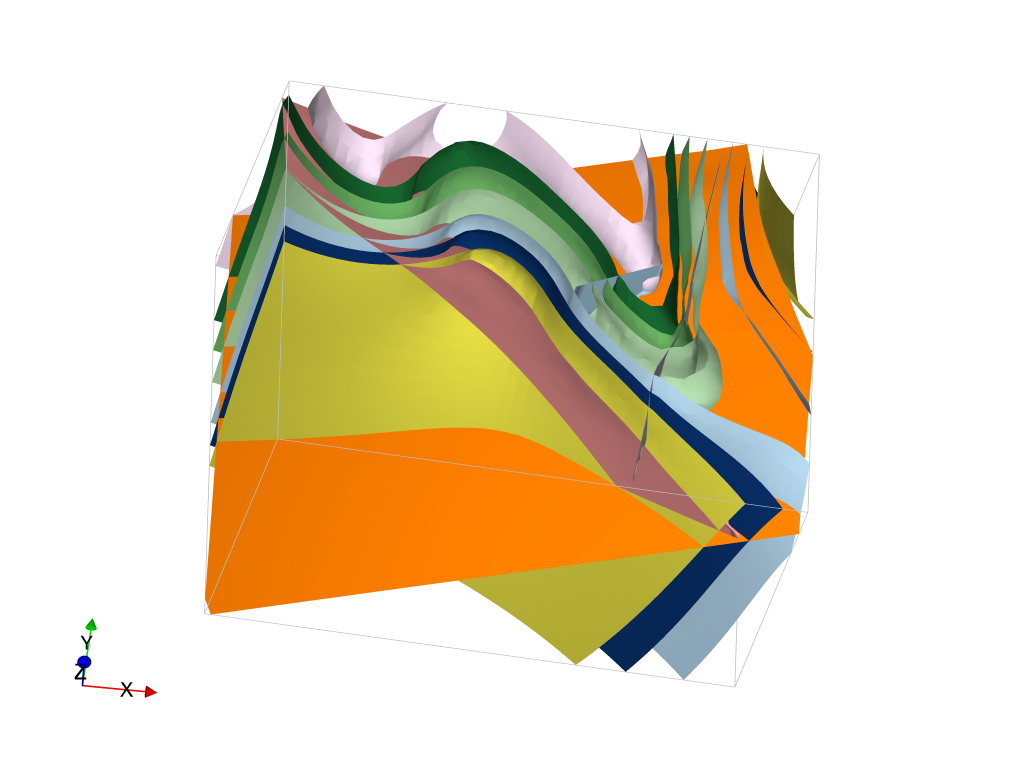

In [22]:
view = LavaVuModelViewer(model)

# view.nelements = 1e5
all_names = []
all_values = []

colores = [ ['#f7dff3'] , 
            ['#17632e'], 
            ['#6cb464'],
            ['#b5dfae'], 
            ['#afd1e7'], 
            ['#08306b'], 
            ['#e0d841']
           
           ]

for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])

view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)

view.add_isosurface(model['F1'], colours = ['#a6cee3'], value = 0)
    
# view.add_data(model['Group_0'])
view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
view.display()
# view.interactive()

In [23]:
# build a gif
colores = [ ['#f7dff3'] , 
            ['#17632e'], 
            ['#6cb464'],
            ['#b5dfae'], 
            ['#afd1e7'], 
            ['#08306b'], 
            ['#e0d841']
           
           ]

images = []
resolution = (1024, 768)

camera = {'translation':[0.0, 0.0, -15107.612],'rotation':[73.248, -86.822, -13.913]}

view = LavaVuModelViewer(model)
view.nsteps = [200,200,300]
view.nelements = 1e5
all_names = []
all_values = []
for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
images.append(view.image_array(resolution = resolution))

view.clear()

view = LavaVuModelViewer(model)
view.nsteps = [200,200,300]
view.nelements = 1e5
all_names = []
all_values = []
for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)

view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
images.append(view.image_array(resolution = resolution))

view.clear()

view = LavaVuModelViewer(model)
view.nsteps = [200,200,300]
view.nelements = 1e5
all_names = []
all_values = []
for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
images.append(view.image_array(resolution = resolution))

view.clear()

view = LavaVuModelViewer(model)
view.nsteps = [200,200,300]
view.nelements = 1e5
all_names = []
all_values = []
for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                   colours = colores[i], 
                    names = [all_names[i]])
view.add_isosurface(model['Black Flag Fault'], colours = ['grey'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['F1'], colours = ['#a6cee3'], value = 0)
view.rotation = [-32.32075119018555, 9.636723518371582, -7.883737087249756]
images.append(view.image_array(resolution = resolution))

In [24]:
import imageio
imageio.mimsave('outputs/movie.gif', images, fps = 1)

In [25]:
view.export_to_webgl('outputs/model_no_fold_frame.html')